# Safety Band
Driver safety issue is a challenging problem in the world. Nowadays, we can leverage the power of big data and artificial intelligent on this problem. Grab is a company dedicated to provided safe and convinient transporation services to public. Today, Grab is present in eight countries across the region and become one of the largest transportation sharing platform in South East Asia.

Remark: This notebook is to demonstrate our idea based on data analytics, working codes are written in train.py and predict.py. Sorry for any inconvenience if the code not looks clean enough.

## Problem
Dangerous driving is one of the main cause of deathly accidents. To ensure safety of drivers and passengers, we need to identify dangerous driving behaviours and educate drivers with safety driving behaviour. However, it's not easy to detect dangerous driving 
- **How to detect driver is driving dangerously based on telematics data?**

## Contents:
- Data Processing
- Data Analysis
- Deep Learning Model
- Proposed Safety Band

## Import libraries

In [2]:

from os import listdir
from os.path import isfile, join
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import scipy
import numpy as np
from tqdm import tqdm
import random

import keras
import tensorflow as tf
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import Model
from keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from tqdm import tqdm # Processing time measurement
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split 
from keras import backend as K # The backend give us access to tensorflow operations and allow us to create the Attention class
from keras import optimizers # Allow us to access the Adam class to modify some parameters
from sklearn.model_selection import GridSearchCV, StratifiedKFold # Used to use Kfold to train our model
from keras.callbacks import * # This object helps the model to train in a smarter way, avoiding overfitting
print(keras.__version__)
print(tf.__version__)
import lightgbm as lgb

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from IPython.display import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

2.1.4
1.4.0


## Assumption

1) Label given not 100% correct (Driving safetiness can be very subjective)

2) Data collect by using mobile device(smartphone), stability of smartphone placed in car is uncertain for different driver which will affect the data collected.

3) Smartphone are in stand position

4) In most case, acceleration x and gyro x represent movement in car turning left & right

5) In most case, acceleration z and gyro z represent movement in car turning font & back

4) In most case, acceleration y and gyro y represent movement in car turning up & down


## Data Preprocessing

### Read data and labels

We read the data and label from the source file given. Dataset given is splited into 10 csv files. It's necessary to merge and sort it based on the bookingID and time. Some of the label has multiple or invalid class, we remove it as well.

In [4]:
label = pd.read_csv("data/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

#Sort the label with booking ID and remove rows with duplicate classes
label_clear = label.sort_values("bookingID",ascending=True).drop_duplicates('bookingID',keep=False).reset_index(drop=True).set_index("bookingID")
label_clear['label'] = label_clear['label'].apply(lambda x:int(x))

#Create dictionary for booking ID and it's label
label_dict = label_clear.to_dict()
label_dict = label_dict['label']

# function to match label for telematic data 
def findLabel(x):
    try:
        return label_dict[x]
    except KeyError:
        return np.nan

In [5]:
# Read all csv
FILES = 'features'
csvfiles = [f for f in listdir(FILES)]
df_all = pd.read_csv(FILES + "/"+csvfiles[0])
for csv in csvfiles[1:]:
    print("getting "+ csv + "...")
    df = pd.read_csv(FILES+"/"+csv)
    df_all = df_all.append(df, ignore_index=True)

#Merge, sort and clean the data
df_drives = df_all.sort_values(['bookingID', 'second'], ascending=[True, True])
df_drives['label'] = df_drives['bookingID'].apply(lambda x: findLabel(x))
df_drives = df_drives.reset_index(drop=True)
df_drives = df_drives.loc[:, ~df_drives.columns.str.contains('^Unnamed')]
df_drives = df_drives.dropna()
print(df_drives.shape)


getting part-00005-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00006-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00002-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting .DS_Store...


/home/yapws/kenv/local/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




getting part-00003-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00009-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00004-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00001-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
getting part-00007-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv...
(16116704, 12)


### How the label looks like?
We analyze the ratio of label in between dangerous and safe driving. We find out that the safe driving is 3 times outnumber the dangerous driving where 75% of the trip is safe and the rest is dangerous.

In [79]:
print(label_clear['label'].value_counts())
safe = df_drives.reset_index().drop_duplicates('bookingID',keep='last').groupby('label')['label'].count()[0]
unsafe = df_drives.reset_index().drop_duplicates('bookingID',keep='last').groupby('label')['label'].count()[1]
print('ratio of safe to dangerous trip',safe/float(unsafe))

0    14999
1     4983
Name: label, dtype: int64

### How the data looks like?

In [ ]:
print(df_drives.info())

So it has 11 columns in total.Each trip will be assigned with label 1 or 0 in a separate label file to indicate dangerous driving.

| Field | Description |
|------|------|
| bookingID | trip id |
| Accuracy | accuracy inferred by GPS in meters |
| Bearing | GPS bearing in degree |
| acceleration_x | accelerometer reading at x axis (m/s2) |
| acceleration_y | accelerometer reading at y axis (m/s2) |
| acceleration_z | accelerometer reading at z axis (m/s2) |
| gyro_x | gyroscope reading in x axis (rad/s)) |
| gyro_y | gyroscope reading in y axis (rad/s) |
| gyro_z | gyroscope reading in z axis (rad/s) |
| second | time of the record by number of seconds |
| Speed | speed measured by GPS in m/s |

### Duration for trips
We interested in how long does these trips travelled and we do a quick analysis on it. We can see that most of the trip ended before 1700s (30 minutes). Also, we can see that many of trips is in duration in between 200s to 1000s (3 to 17 minutes).

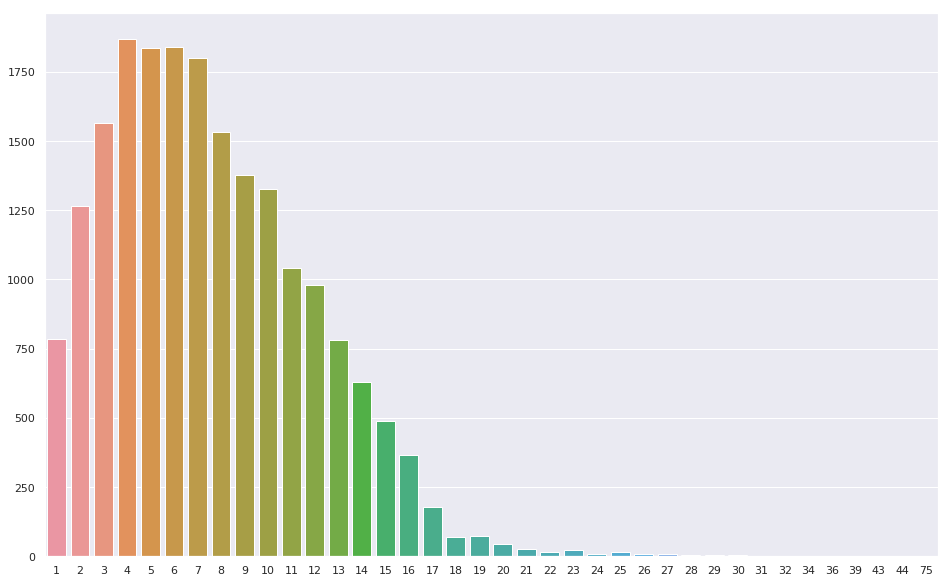

Int64Index([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
            1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
            2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3400,
            3600, 3900, 4300, 4400, 7500],
           dtype='int64')
[ 786 1264 1565 1870 1835 1841 1801 1534 1379 1327 1041  979  782  629
  490  367  178   69   72   44   25   17   24    9   15    8    7    6
    5    3    2    1    1    2    1    1    1    1]


In [68]:
def round_by(x,base):
    return int(x/float(base))*base

df_plot = df_drives.groupby('bookingID').count()['second'].apply(lambda x: round_by(x,100)).value_counts().sort_index()
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x=df_plot.index/100, y=df_plot.values)
plt.xlabel('Duration (x100s)')
plt.ylabel('Number of trips')
plt.show()

### Accuracy
We also study the accuracy inferred by the GPS. Most of the data rows has good accuracy ( error less than 100m ). Although there are some inaccurate datas, but the accuracy actually brings very little effect as the accelerator and gyrometer does not rely on GPS reading.

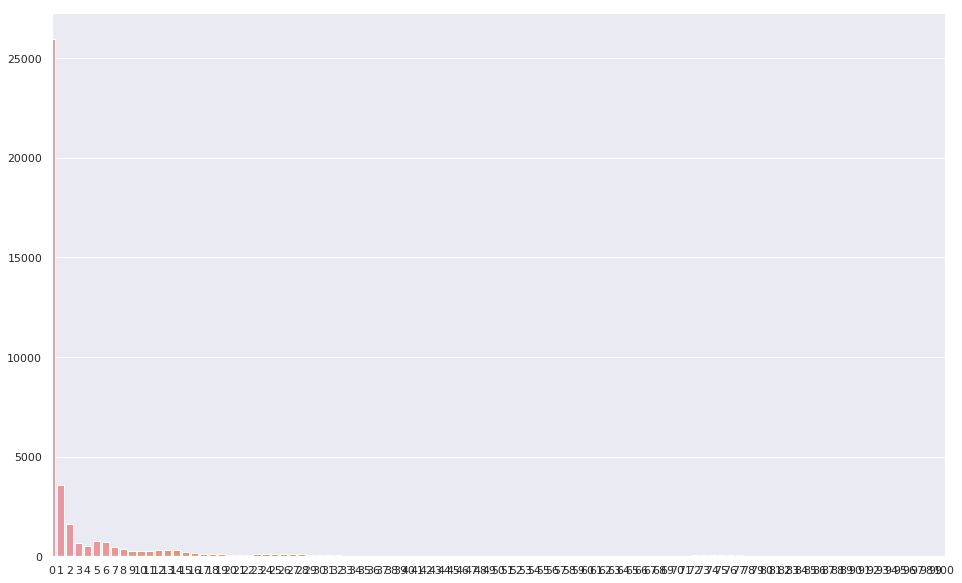

In [95]:
df_plot = df_drives_booking.groupby('Accuracy').count()['second'].apply(lambda x: round_by(x,10)).value_counts().sort_index()
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.barplot(x=df_plot.index/10, y=df_plot.values)
ax.set(xlim=(0,100))
plt.xlabel('Accuracy in meter (x100)')
plt.ylabel('Number of trips')
plt.show()

### Analysis on acceleration, gyro and Speed readings

We further analyse the other information we have in the data. Now, we look into acceleration and gyro in x,y and z axis. The distribution of these data for safe and dangerous driving is computed and plotted. 

In [138]:
BookingID = label_clear.index
df_plot = df_drives_booking

def get_var_plot(column):
    for ID in BookingID:
        try:
            df_id = df_drives_booking.loc[ID].reset_index(drop=True)
            
            #get variation of column 
            df_plot.loc[ID,'var'] = df_id[column].var()
            
        except KeyError:
            continue
            
    fig, ax = plt.subplots(figsize=(16,9))
    ax = sns.boxplot(x=df_plot["label"], y=df_plot["var"])
    ax.set_title("varation of acceleration in " + column)
    plt.show()
    
    #compute the mean of feature
    mean = df_plot.reset_index().drop_duplicates('bookingID',keep='first').groupby('label')['var'].mean()
    
    #compute the standard deviation of feature
    std = df_plot.reset_index().drop_duplicates('bookingID',keep='first').groupby('label')['var'].std()
    
    print('mean for var in column '+column)
    print(mean)
    print('standard deviation for var in column '+column)
    print(std)

**We first imagined a greatly distinct distribution we will get for safe and dangerous driving. However, the distribution we obtained for both classes is very closed to each other.**

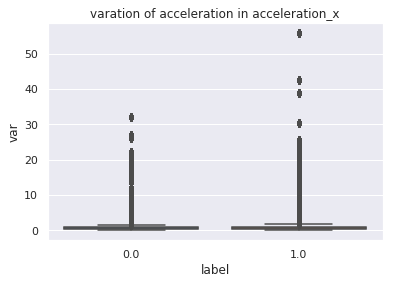

('mean for var in columnacceleration_x', label
0.0    0.804051
1.0    1.368669
Name: var, dtype: float64)
('\nstandard deviation for var in columnacceleration_x', label
0.0    1.054455
1.0    3.014761
Name: var, dtype: float64)


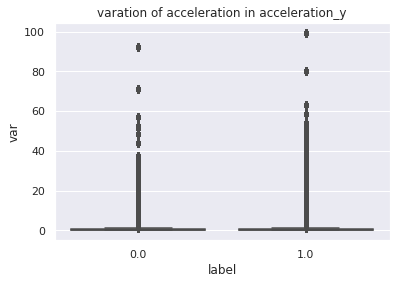

('mean for var in columnacceleration_y', label
0.0    0.741472
1.0    1.948124
Name: var, dtype: float64)
('\nstandard deviation for var in columnacceleration_y', label
0.0    2.338117
1.0    6.341168
Name: var, dtype: float64)


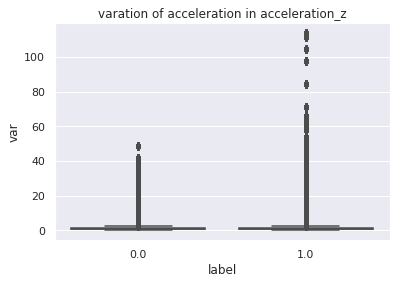

('mean for var in columnacceleration_z', label
0.0    1.200632
1.0    2.550980
Name: var, dtype: float64)
('\nstandard deviation for var in columnacceleration_z', label
0.0    1.709825
1.0    7.430878
Name: var, dtype: float64)


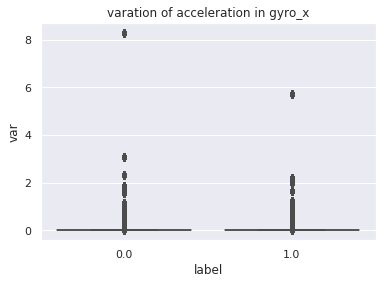

('mean for var in columngyro_x', label
0.0    0.014198
1.0    0.033345
Name: var, dtype: float64)
('\nstandard deviation for var in columngyro_x', label
0.0    0.096266
1.0    0.153200
Name: var, dtype: float64)


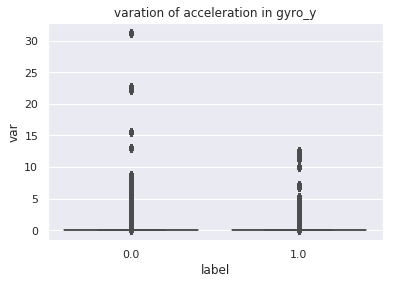

('mean for var in columngyro_y', label
0.0    0.061580
1.0    0.096136
Name: var, dtype: float64)
('\nstandard deviation for var in columngyro_y', label
0.0    0.563531
1.0    0.570746
Name: var, dtype: float64)


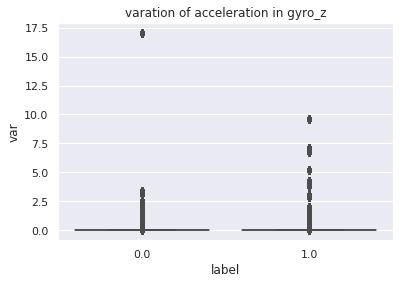

('mean for var in columngyro_z', label
0.0    0.013425
1.0    0.045282
Name: var, dtype: float64)
('\nstandard deviation for var in columngyro_z', label
0.0    0.172325
1.0    0.323860
Name: var, dtype: float64)


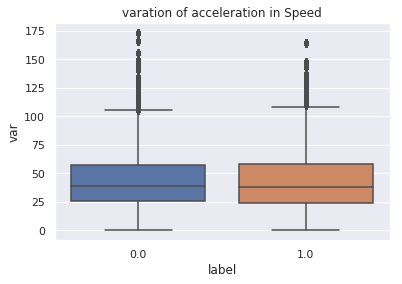

('mean for var in columnSpeed', label
0.0    39.101377
1.0    38.947895
Name: var, dtype: float64)
('\nstandard deviation for var in columnSpeed', label
0.0    22.453393
1.0    24.914337
Name: var, dtype: float64)


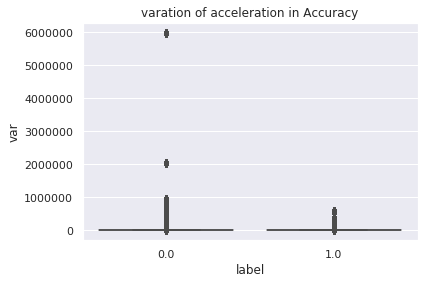

('mean for var in columnAccuracy', label
0.0    3409.866113
1.0    1886.708344
Name: var, dtype: float64)
('\nstandard deviation for var in columnAccuracy', label
0.0    63791.156840
1.0    23573.755045
Name: var, dtype: float64)


In [140]:
get_var_plot('acceleration_x')
get_var_plot('acceleration_y')
get_var_plot('acceleration_z')
get_var_plot('gyro_x')
get_var_plot('gyro_y')
get_var_plot('gyro_z')
get_var_plot('Speed')

## Data Sampling

We then sample the data randomly to smaller set by remaining the ratio of safe to dangerous driving. The reason we sample the data is to reduce the time for training or running this script. We only use 15% of the whole dataset but we ensure every trip is completed trip.

Remark: Small data does not affect the performance of our model much.

In [6]:
#Percentage to drop
DROP_PERC = 0.85

# Randomly sample the row to drop
dropID = random.sample(list(label_clear.index),int(len(label_clear)*DROP_PERC))
dropID = map(float, dropID)

#Sampling
print(df_drives.shape)
df_sampled = df_drives.set_index('bookingID').drop(dropID)
print(df_sampled.shape)

sampleID = list(df_sampled.index.drop_duplicates(keep='first'))
df_sampled.to_csv('data/sampled_'+DROP_PERC+'.csv')

(16116704, 12)
(2396538, 11)


In [9]:
df_sampled = pd.read_csv('data/sampled_85.csv')
len(df_sampled.bookingID.unique())
sampleID = list(df_sampled.set_index('bookingID').index.drop_duplicates(keep='first'))

## Deep Learning 
As the data is processed and clean, we move to test out some deep learning model to predict the safe or dangerous driving. We use the raw data to do that and the only feature engineering we do is normalization because we tried some signal processing and the result is not promising.

There are two model we going to apply here:
- LSTM with Attention
- Convolutional Neural Network

Remark: We drop the data that has excessive duration as we know LSTM and CNN model require fixed dimension inputs.

In [7]:
#drop trip with duration larger than 1300 seconds
df_drop_long = df_drives.drop_duplicates('bookingID',keep='last').reset_index(drop=True).set_index("bookingID")
drop_list=df_drop_long[df_drop_long['second']>1300].index

df_drives_booking = df_drives.set_index('bookingID')
print(df_drives_booking.shape)
df_drives_booking.drop(drop_list, inplace=True)
print(df_drives_booking.shape)

(16116704, 11)
(10260587, 11)


In [10]:
def normalize(df,features_normalize):
    #normalize the value from 0.2 to 0.7 
    normalizer = MinMaxScaler(feature_range=(0.2,0.7))
    for f in features_normalize:
        df[f]=normalizer.fit_transform(df[f].values.reshape(-1, 1))
    return df

### Training data generation
This section is to generate training samples for our deep learning model.

In [11]:
sample_size = 1300
features = ['acceleration_x','acceleration_y','acceleration_z','gyro_x'
            ,'gyro_y','gyro_z','Speed']
features_normalize = ['acceleration_x','acceleration_y','acceleration_z','gyro_x'
            ,'gyro_y','gyro_z','Speed']
features_normalize = ['acceleration_x','acceleration_z','Speed']

def prep_data(df):
    x = []
    y = []
    for ID in tqdm(label_clear.index):
        try:
            data = df[df.index==ID].reset_index(drop=True)
            if len(data) > 500:
                data = normalize(data,features_normalize)
                x_padding = [0 for i in range(len(features))]
                if len(data)<sample_size:
                    x_id = []
                    for row_index, row in data.iterrows():
                        x_id.append([row[f] for f in features])

                    for extra in range(sample_size-len(data)):
                        x_id.append(x_padding)
                    x.append(x_id)
                else:
                    x_id = []
                    for row_index, row in data.iterrows():
                        if row_index < sample_size:
                            x_id.append([row[f] for f in features])
                    x.append(x_id)
                y.append(label_dict[ID])
        except KeyError:
            continue
    X = np.asarray(x)
    Y = np.asarray(y)

    print('x_shape',X.shape)
    print('y_shape',Y.shape)
    return X,Y

X,Y = prep_data(df_sampled)

100%|██████████| 19982/19982 [03:32<00:00, 93.84it/s] 


('x_shape', (2163, 1300, 7))
('y_shape', (2163,))


In [12]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [13]:
def model_lstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(input_shape[1], input_shape[2])))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Attention(input_shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model


In [14]:
def model_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=512, kernel_size=16, activation='relu', input_shape=(input_shape[1],input_shape[2])))
    model.add(Conv1D(filters=512, kernel_size=16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [ ]:
EPOCH = 10
BATCH = 128

# Here is where the training happens
# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=2017).split(X, Y))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], Y[train_idx], X[val_idx], Y[val_idx]
    model = model_cnn(train_X.shape)
    ckpt = ModelCheckpoint('weights_cnn{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_acc', mode='max')
    model.fit(train_X, train_y, batch_size=BATCH, epochs=EPOCH, validation_data=[val_X, val_y], callbacks=[ckpt],verbose=1,)
    
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_cnn{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=16))
    y_val.append(val_y)

# concatenates all and prints the shape    
preds_val = np.concatenate(preds_val)[...,0]

Beginning fold 1
Train on 1441 samples, validate on 722 samples
Epoch 1/10
1441/1441 [==============================] - 7s 5ms/step - loss: 5.0553 - acc: 0.6551 - val_loss: 4.3755 - val_acc: 0.7285

Epoch 00001: val_acc improved from -inf to 0.72853, saving model to weights_cnn0.h5
Epoch 2/10
1441/1441 [==============================] - 6s 4ms/step - loss: 4.3623 - acc: 0.7294 - val_loss: 4.3755 - val_acc: 0.7285

Epoch 00002: val_acc did not improve
Epoch 3/10
1441/1441 [==============================] - 6s 4ms/step - loss: 4.3623 - acc: 0.7294 - val_loss: 4.3755 - val_acc: 0.7285

Epoch 00003: val_acc did not improve
Epoch 4/10
1441/1441 [==============================] - 6s 4ms/step - loss: 4.3623 - acc: 0.7294 - val_loss: 4.3755 - val_acc: 0.7285

Epoch 00004: val_acc did not improve
Epoch 5/10
1441/1441 [==============================] - 6s 4ms/step - loss: 4.3623 - acc: 0.7294 - val_loss: 4.3755 - val_acc: 0.7285

Epoch 00005: val_acc did not improve
Epoch 6/10
1441/1441 [=======

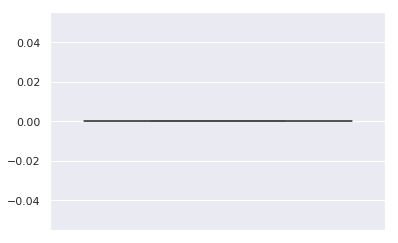

0.0

In [34]:
ax = sns.boxplot(y=list(preds_val))
plt.show()

In [36]:
EPOCH = 10
BATCH = 128

# Here is where the training happens
# First, create a set of indexes of the 5 folds
splits = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=2017).split(X, Y))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))
    # use the indexes to extract the folds in the train and validation data
    train_X, train_y, val_X, val_y = X[train_idx], Y[train_idx], X[val_idx], Y[val_idx]
    model = model_lstm(train_X.shape)
    ckpt = ModelCheckpoint('weights_{}.h5'.format(idx), save_best_only=True, save_weights_only=True, verbose=1, monitor='val_acc', mode='max')
    model.fit(train_X, train_y, batch_size=BATCH, epochs=EPOCH, validation_data=[val_X, val_y], callbacks=[ckpt],verbose=1,)
    
    # loads the best weights saved by the checkpoint
    model.load_weights('weights_{}.h5'.format(idx))
    # Add the predictions of the validation to the list preds_val
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)
    
preds_val = np.concatenate(preds_val)[...,0]
preds_val.shape, y_val.shape

Beginning fold 1
Train on 1160 samples, validate on 581 samples
Epoch 1/10
1160/1160 [==============================] - 84s 73ms/step - loss: 0.6379 - acc: 0.6422 - val_loss: 0.8297 - val_acc: 0.3976

Epoch 00001: val_acc improved from -inf to 0.39759, saving model to weights_0.h5
Epoch 2/10
1160/1160 [==============================] - 82s 71ms/step - loss: 0.6170 - acc: 0.7052 - val_loss: 0.6645 - val_acc: 0.7453

Epoch 00002: val_acc improved from 0.39759 to 0.74527, saving model to weights_0.h5
Epoch 3/10
1160/1160 [==============================] - 83s 72ms/step - loss: 0.5903 - acc: 0.7448 - val_loss: 0.6352 - val_acc: 0.6145

Epoch 00003: val_acc did not improve
Epoch 4/10
1160/1160 [==============================] - 83s 72ms/step - loss: 0.5867 - acc: 0.7319 - val_loss: 0.6840 - val_acc: 0.4096

Epoch 00004: val_acc did not improve
Epoch 5/10
1160/1160 [==============================] - 82s 71ms/step - loss: 0.5923 - acc: 0.6974 - val_loss: 0.5684 - val_acc: 0.7453

Epoch 00005:

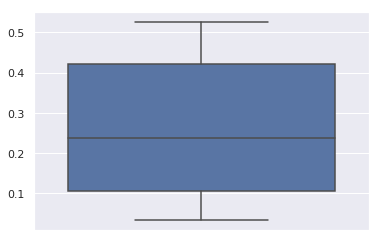

In [42]:
ax = sns.boxplot(y=preds_val)
plt.show()

## Summary of deep learning model:

After we tried both LSTM and CNN model with different hyperparameters, we find it find difficulties in recognising either safe or dangerous trip. The model achieve accuracy of 70+% because they predict only to one class which is 0, which make it get correct prediction on 75% of safe trip. This do not make any sense for a good classfier. Then, we decided to focus on dangerous moments instead of classifying the whole trip.

# Proposed Idea: Safety band insight by Bollinger band.
Based on analytic of data and some attempts to classify the trip, We've decided to focus on identify the possible dangerous moments in a trip instead of classify safety or dangerous per trip. This idea come from Bollinger Band in the stock market. 

![N|Solid](https://a.c-dn.net/c/content/igcom/en_GB/ig-financial-markets/market-news-and-analysis/trading-strategies/2018/11/27/trading-with-bollinger-bands/jcr%3Acontent/newspar3/panel_child_604225165/mp-parsys2/textimage/image.webimg.png/1543324397375.png)

**Bollinger band** is a famous technical analysis tools used in stock trading that provide relative definitions of high and low that can be used to create rigorous trading approaches. Here, we apply the idea of bollinger band with machine learning to detect any abnormal driving behaviours. We trained a regression model to predict this safety band for multiple features based on the safe driving data (class is 0). In prediction, any values that exceed this safety band will trigger a warning that indicate possible of dangerous action as shown. 

let's take speed for example:

The proposed idea has advantages as follow:
- Can igonore the uncertainties (The way smartphone placed in car, Performance of the car, Concept of dangerous for passengers)
- Fair for both drivers and passengers, avoid unnecessary argues (No blackbox operation, can trace back the dangerous moments)
- No time restriction as trip come with various duration and deep learning model are mostly require fixed dimensions of inputs

## Example of apply Bollinger's band in driving telematics data
First, let's look at the equation of Bollinger's band.

![N|Solid](https://www1.oanda.com/wandacache/2017_bollingerbandsformula-91337ad4d173ccef8e6057242e2188e2fbfc28d2.png)

Bollinger's band use means and standard deviations from previous fixed durations. Let's see how a 20 second Bollinger's band for telematics data (Speed) will looks like.


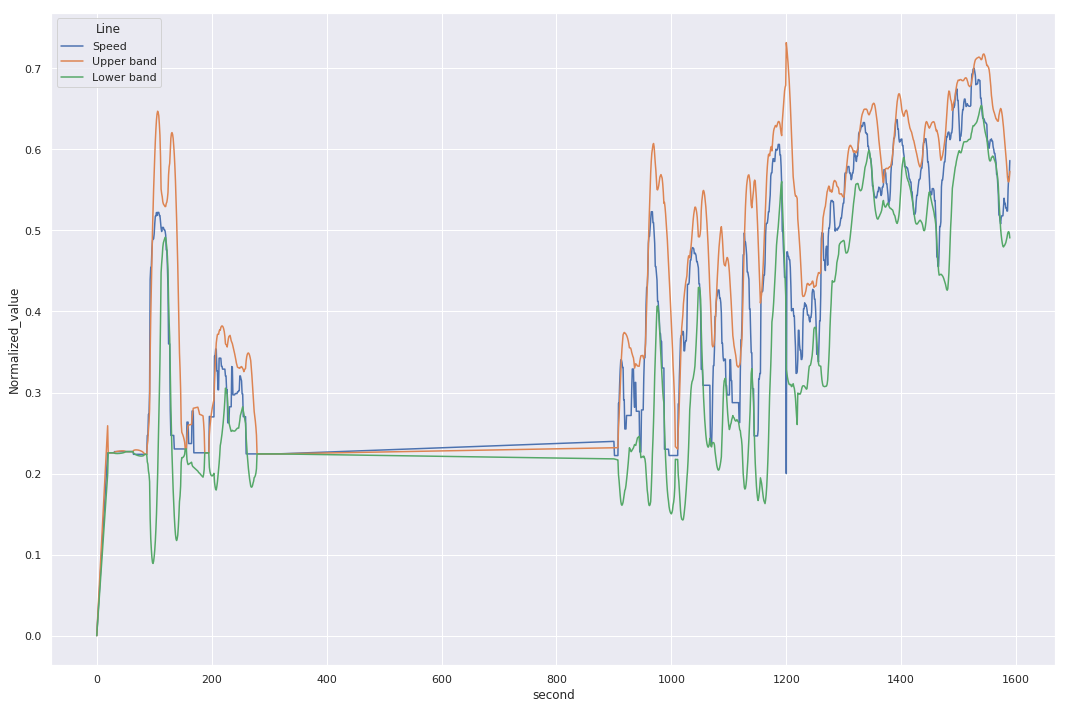

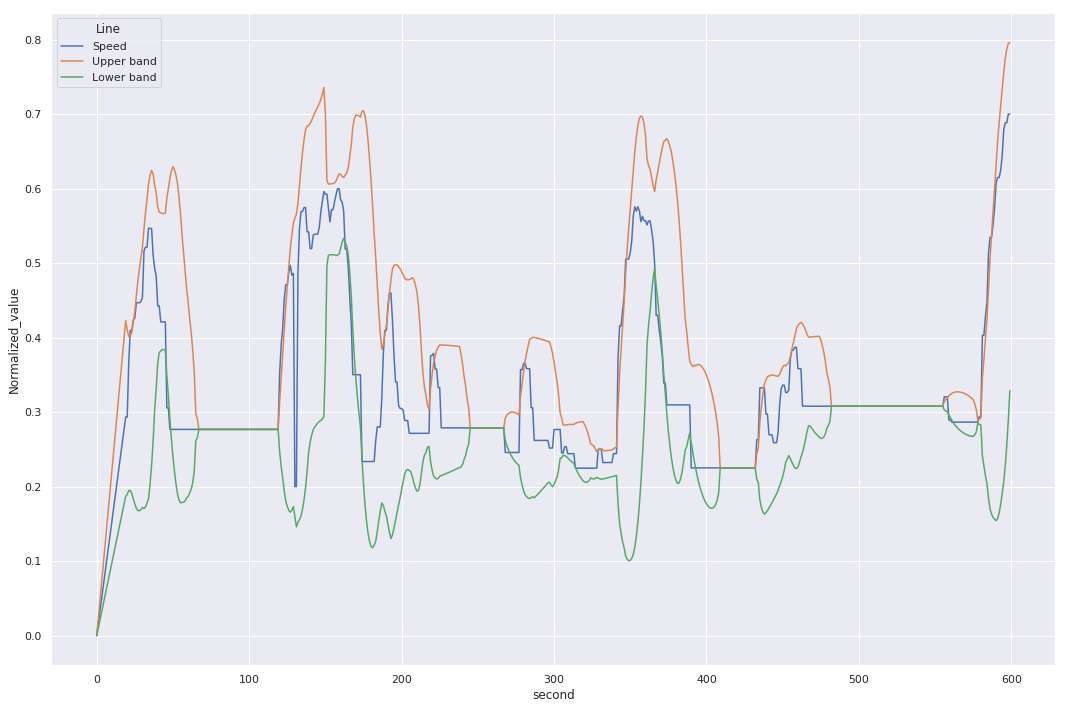

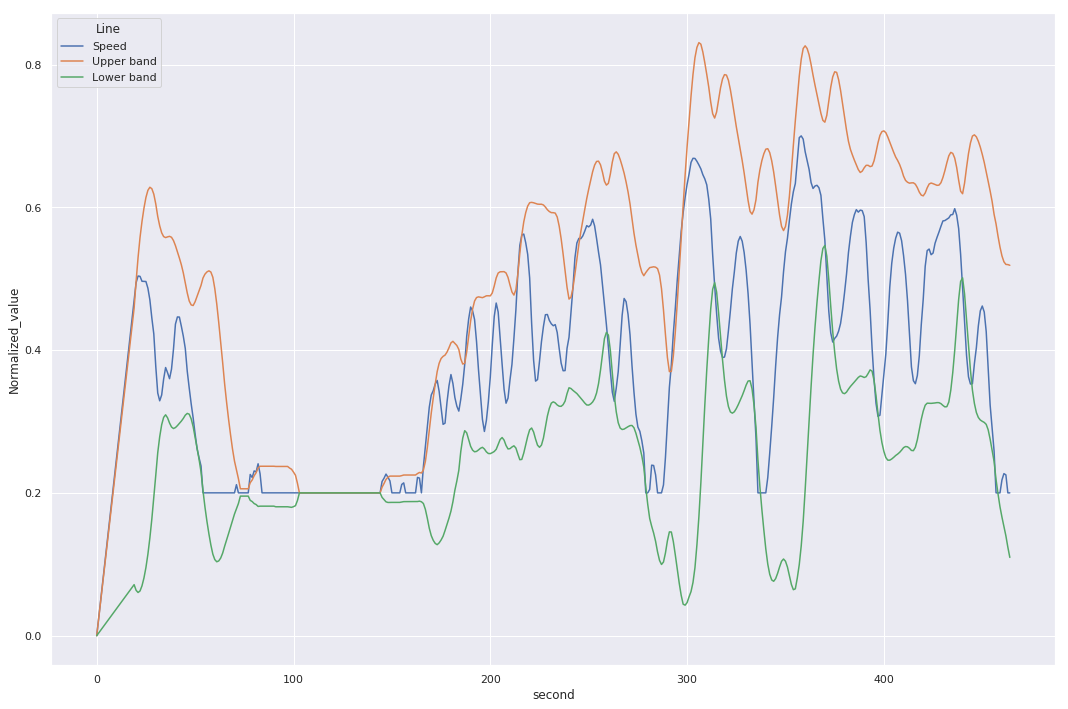

In [74]:
FEATURES = ['Speed']
columns = df_sampled.columns
df = df_sampled.set_index('bookingID')

for ID in sampleID[:3]:
    df_id = df[df.index==ID].reset_index(drop=True)
    if len(df_id>0):
        
        # Generate Bollinger band for features
        df_id = normalize(df_id,FEATURES)
        for F in FEATURES:
            df_id['20MA'] = df_id[F].rolling(window=20).mean()
            df_id['_20STD'] = df_id[F].rolling(window=20).std()
            df_id['Upperband'] = df_id['20MA'] + df_id['_20STD']*2
            df_id['Lowerband'] = df_id['20MA'] - df_id['_20STD']*2
        df_id.loc[-1]=[0 for i in range(len(df_id.columns))]
        df_id.index = df_id.index+1
        df_id = df_id.sort_index()
        df_id = df_id.dropna().reset_index(drop=True)
        
        #plot the graph
        fig, ax = plt.subplots(figsize=(18,12))
        ax = sns.lineplot(x="second", y=F, data=df_id)
        ax = sns.lineplot(x="second", y='Upperband', data=df_id)#orange left/right
        ax = sns.lineplot(x="second", y='Lowerband', data=df_id)#purple left/right
        plt.legend(title='Line', loc='upper left', labels=[F, 'Upper band', 'Lower band'])
        plt.ylabel('Normalized_value')
        plt.show()
 

### How safety band can help in detect abnormal or dangerous driving behaviours

Detecting a dangerous trip is not practical and useful at the moment because these dangerous moments sometimes very short or sudden in duration. By setting a safety band, we can find out the dangerous moments in trip no matter it's label as safe or dangerous. This solution is practical as abnormal driving behaviors can happen in both safe or dangerous drivers. Also, the safety band give a clear defination of abnormal unlike deep learning model. Deep learning model usually known as black box. In NN, it's difficult for human to interpret it's decision. When it come to arguement in between driver and passenger, we cannot hand any prove to protect the benefit of both sides.

### Safety band with machine learning
We propose to train a safety band on top of driving's telematic data. Any machine learning or deep learning model that can perform solve regression problem are allowed to use. In here, we use a simple lightgbm to predict safety band for each sensors data. Features that we select are as follow:

- Moving average 
- Standard deviation

In default, we use 10, 20 and 30 seconds to compute moving average and standard deviation. The lightgbm model will learn the significant of each features according to the training data. One thing to mention, we use only safe trip (labeled as 0) as our training data because we want the safety band trained from safe driving samples.

### Features and training samples generation

In [53]:
FEATURES = ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','Speed']
BAND_GAP_RATIO = 0.3
columns = df_sampled.columns
BookingID = label_clear.index
dangerousID=[]
safeID = []
data_train = df_sampled.set_index('bookingID')

#create training and testing list
dtrain = pd.DataFrame([[0 for i in range(len(df_sampled.columns))]])
dtest = pd.DataFrame([[0 for i in range(len(df_sampled.columns))]])
dtrain.columns = columns
dtest.columns = columns

for ID in sampleID:
    df_id = data_train[data_train.index==ID].reset_index(drop=True)
    if len(df_id>0):
        df_id = normalize(df_id,FEATURES)
        for F in FEATURES:
            #generate extra features
            df_id[F + '_10MA'] = df_id[F].rolling(window=10).mean()
            df_id[F + '_10STD'] = df_id[F].rolling(window=10).std()
            df_id[F + '_20MA'] = df_id[F].rolling(window=20).mean()
            df_id[F + '_20STD'] = df_id[F].rolling(window=20).std()
            df_id[F + '_30MA'] = df_id[F].rolling(window=30).mean()
            df_id[F + '_30STD'] = df_id[F].rolling(window=30).std()
            df_id[F + '_Upperlabel'] = df_id[F] + df_id[F]*BAND_GAP_RATIO
            df_id[F + '_Lowerlabel'] = df_id[F] - df_id[F]*BAND_GAP_RATIO
        df_id.loc[-1]=[0 for i in range(len(df_id.columns))]
        df_id.index = df_id.index+1
        df_id = df_id.sort_index()
        df_id = df_id.dropna().reset_index(drop=True)
        try:
            if label_dict[ID] == 0:
                dtrain = dtrain.append(df_id, ignore_index=True)
            else:
                dtest = dtest.append(df_id, ignore_index=True)
        except KeyError:
            continue
        
print(dtrain.head())

   Accuracy     Bearing     Speed  Speed_10MA   Speed_10STD  Speed_20MA  \
0       0.0    0.000000  0.000000         NaN           NaN         NaN   
1       0.0    0.000000  0.000000    0.000000  0.000000e+00    0.000000   
2       8.0  143.298294  0.225650    0.225650  6.208817e-10    0.225650   
3       8.0  143.298294  0.225650    0.225650  6.208817e-10    0.225650   
4      12.0  143.298294  0.227098    0.225795  4.578506e-04    0.225723   

   Speed_20STD  Speed_30MA  Speed_30STD  Speed_Lowerlabel  ...  gyro_z_10MA  \
0          NaN         NaN          NaN               NaN  ...          NaN   
1     0.000000    0.000000     0.000000          0.000000  ...     0.000000   
2     0.000000    0.227888     0.012254          0.157955  ...     0.528432   
3     0.000000    0.225650     0.000000          0.157955  ...     0.527686   
4     0.000324    0.225699     0.000264          0.158969  ...     0.531681   

   gyro_z_10STD  gyro_z_20MA  gyro_z_20STD  gyro_z_30MA  gyro_z_30STD  \
0

### Safety band for different features( acceleretion, gyro and speed)
To train safety band for different features, we use lightgbm as our regression model. The parameters setting is manually tuned which might not be the optimum combinations. However, the performance is good enough to prove the concept. We do not measure AUC ROC for our regression model. Instead, we evaluate the mean square error, the mean square error for models for all features is promising.

In [54]:

FEATURES = ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y','gyro_z','Speed']
FEATURES_STAT = ['10MA','10STD','20MA','20STD','30MA','30STD']

#parameters
max_depth = 8
num_leaves = 8
num_threads = 8
bagging_freq = 5
bagging_fraction = 0.8

train_df = dtrain[:int(round(-(0.2)*dtrain.shape[0]))]
train_df=train_df.drop('bookingID',axis=1)
train_df.dropna(inplace=True)

val_df = dtrain[int(round(-(0.2)*dtrain.shape[0])):]
test_df = dtest
print('length of train data',len(train_df))
print('length of test data',len(test_df))

for F in FEATURES:
    features = [F+'_'+FS for FS in FEATURES_STAT]
    target_upper = train_df[F + '_Upperlabel']
    val_target_upper = val_df[F + '_Upperlabel']
    target_lower = train_df[F + '_Lowerlabel']
    val_target_lower = val_df[F + '_Lowerlabel']
    
    param = {
        #'learning_rate':0.01,
        'bagging_freq': bagging_freq,
        'bagging_fraction': bagging_fraction,
        'boost_from_average':'false',
        'boosting': 'gbdt',
        'feature_fraction': 0.8,
        'learning_rate': 0.0005,
        'max_depth': max_depth,  
        'metric':'mse',
        'min_data_in_leaf': 10,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': num_leaves,
        'num_threads': num_threads,
        'tree_learner': 'serial',
        'objective': 'regression', 
        'verbosity': 1,

    }

    trn_data_upper = lgb.Dataset(train_df[features], label=target_upper)
    val_data_upper = lgb.Dataset(val_df[features], label=val_target_upper)

    trn_data_lower = lgb.Dataset(train_df[features], label=target_lower)
    val_data_lower = lgb.Dataset(val_df[features], label=val_target_lower)

    num_round = 30000
    clf_upper = lgb.train(param, trn_data_upper, num_round, valid_sets=[trn_data_upper, val_data_upper],
        verbose_eval=5000, early_stopping_rounds=10000)
    clf_lower = lgb.train(param, trn_data_lower, num_round, valid_sets=[trn_data_lower, val_data_lower],
        verbose_eval=5000, early_stopping_rounds=10000)

    print('Saving model...')
    # save model to file
    clf_upper.save_model('Weights/'+ F + '_model_upper.txt')
    clf_lower.save_model('Weights/'+ F + '_model_lower.txt')

('length of train data', 1184629)
('length of test data', 541253)
['acceleration_x_10MA', 'acceleration_x_10STD', 'acceleration_x_20MA', 'acceleration_x_20STD', 'acceleration_x_30MA', 'acceleration_x_30STD']
Training until validation scores don't improve for 10000 rounds.
[5000]	training's l2: 0.00612582	valid_1's l2: 0.00540106
[10000]	training's l2: 0.00375813	valid_1's l2: 0.0029887
[15000]	training's l2: 0.00372064	valid_1's l2: 0.00295397
[20000]	training's l2: 0.00370916	valid_1's l2: 0.00294581
[25000]	training's l2: 0.00370187	valid_1's l2: 0.00294131
[30000]	training's l2: 0.00369658	valid_1's l2: 0.00293856
Did not meet early stopping. Best iteration is:
[30000]	training's l2: 0.00369658	valid_1's l2: 0.00293856
Training until validation scores don't improve for 10000 rounds.
[5000]	training's l2: 0.00177612	valid_1's l2: 0.00156599
[10000]	training's l2: 0.00108964	valid_1's l2: 0.000866553
[15000]	training's l2: 0.00107877	valid_1's l2: 0.000856484
[20000]	training's l2: 0.

Saving model...


In [55]:
def normalize_specific(df, index):
    normalizer = MinMaxScaler(feature_range=(index-1,index))
    df=normalizer.fit_transform(df.values.reshape(-1, 1))
    return df

Loading model to predict...
predict trip for ID 0


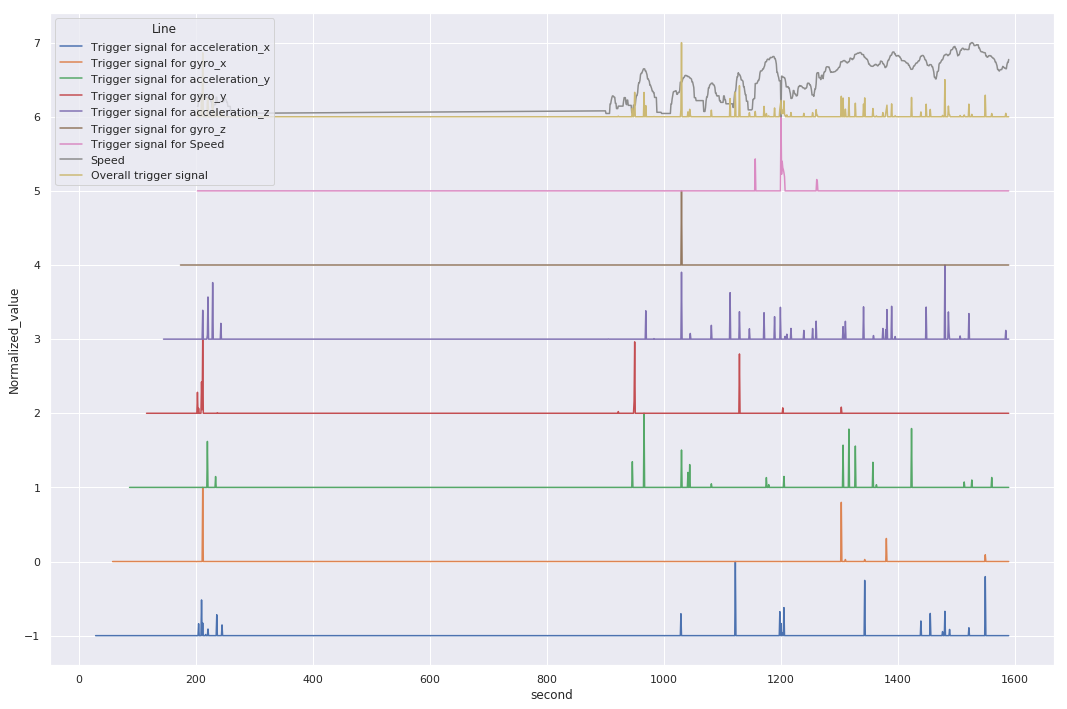

predict trip for ID 14


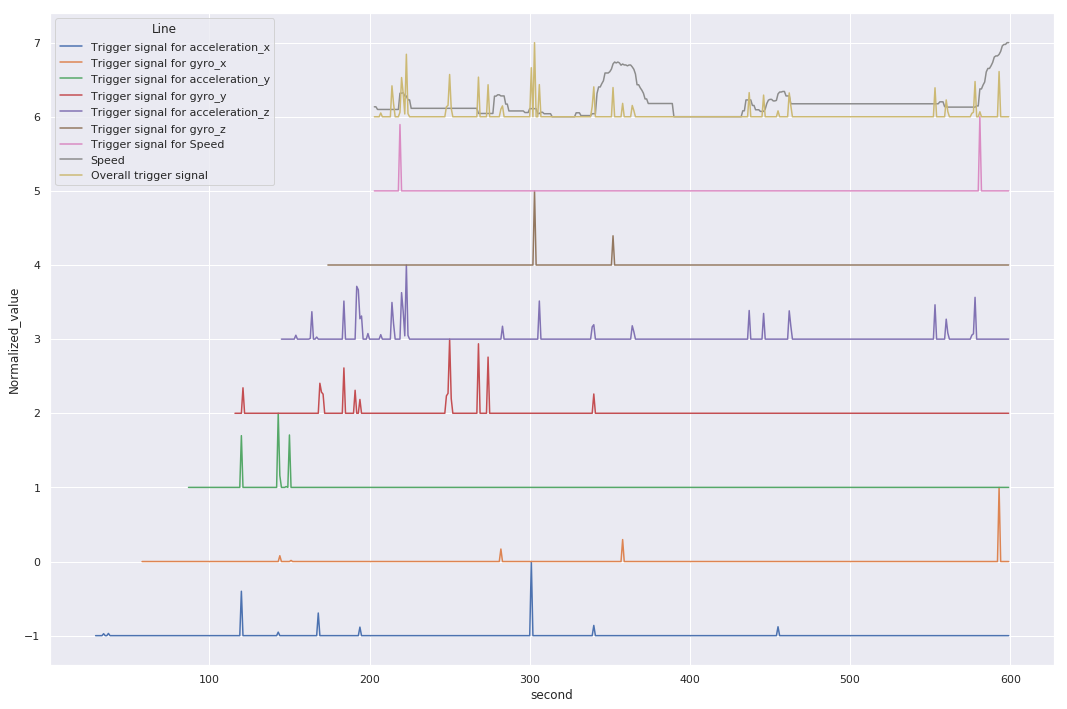

predict trip for ID 21


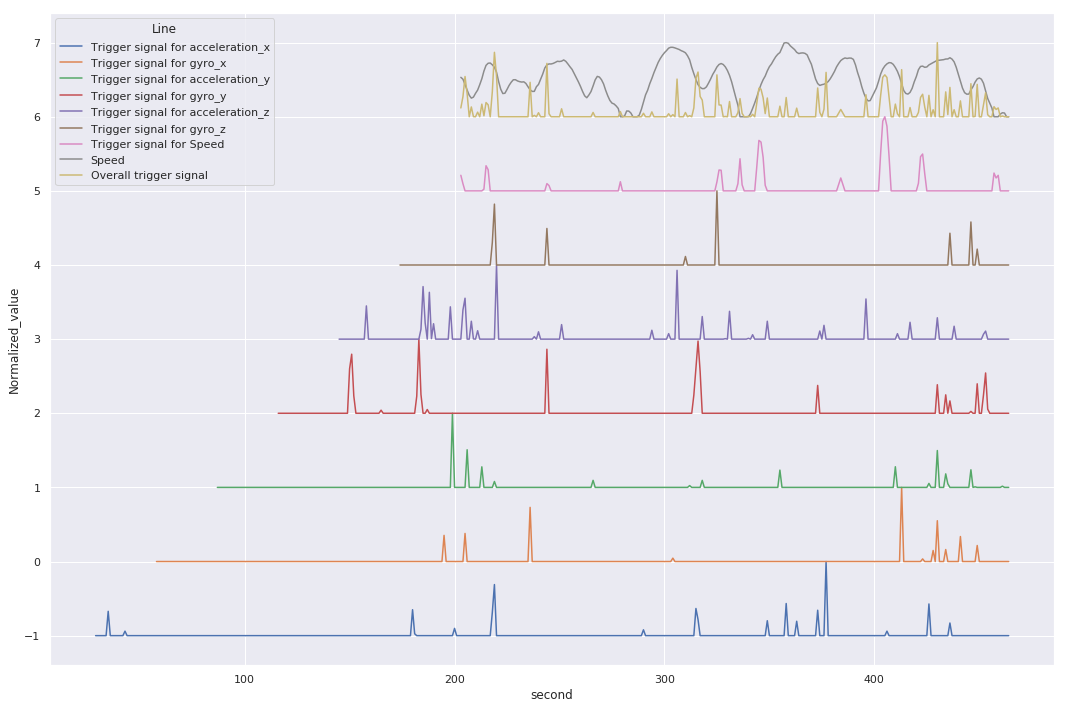

predict trip for ID 27


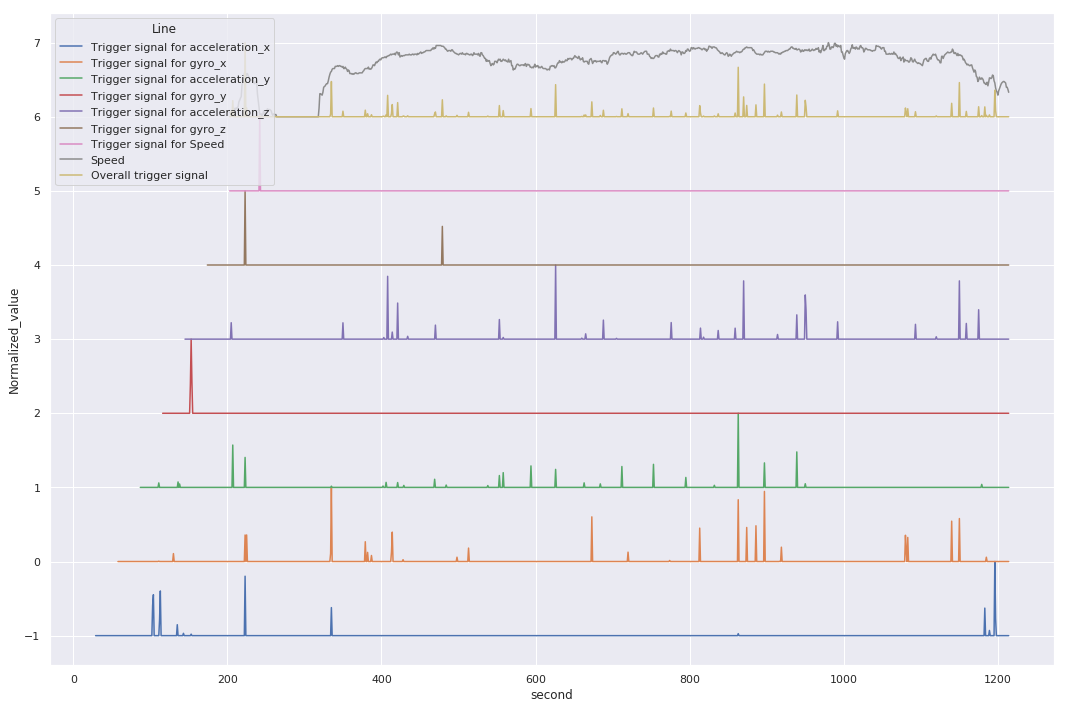

In [79]:
FEATURES = ['acceleration_x','gyro_x','acceleration_y','gyro_y','acceleration_z','gyro_z','Speed']
FEATURES_STAT = ['10MA','10STD','20MA','20STD','30MA','30STD']
print('Loading model to predict...')

for ID in BookingID[:20]:
    traces = []
    df_id = data_train[data_train.index==ID].reset_index(drop=True)
    if len(df_id!=0):
        plot_legend = []
        print('predict trip for ID '+str(ID))
        
        fig, ax = plt.subplots(figsize=(18,12))
        
        for index, F in enumerate(FEATURES):
            features = [F+'_'+FS for FS in FEATURES_STAT]

            # load model to predict
            bst_up = lgb.Booster(model_file='Weights/' + F + '_model_upper.txt')
            bst_low = lgb.Booster(model_file='Weights/' + F +'_model_lower.txt')

            # can only predict with the best iteration (or the saving iteration)
            #y_pred = bst.predict(X_test)
            df_id = normalize(df_id,FEATURES)
            df_id[F + '_10MA'] = df_id[F].rolling(window=10).mean()
            df_id[F + '_10STD'] = df_id[F].rolling(window=10).std()
            df_id[F + '_20MA'] = df_id[F].rolling(window=20).mean()
            df_id[F + '_20STD'] = df_id[F].rolling(window=20).std()
            df_id[F + '_30MA'] = df_id[F].rolling(window=30).mean()
            df_id[F + '_30STD'] = df_id[F].rolling(window=30).std()
            df_id.loc[-1]=[0 for i in range(len(df_id.columns))]
            df_id.index = df_id.index+1
            df_id = df_id.sort_index()
            df_id = df_id.dropna()[1:].reset_index(drop=True)
            
            df_id['upper'] = bst_up.predict(df_id[features], num_iteration=bst_up.best_iteration)
            df_id['lower'] = bst_low.predict(df_id[features], num_iteration=bst_low.best_iteration)
            
            df_id['outofupper'] = df_id['upper']-df_id[F]
            df_id['outoflower'] = df_id['lower']-df_id[F]
            df_id['outofupper'] = df_id['outofupper'].apply(lambda x: max(0,-x))
            df_id['outoflower'] = df_id['outoflower'].apply(lambda x: max(0,x))
            df_id['outofrange'] = df_id['outofupper'] + df_id['outoflower']
            if index == 0:
                df_id['outacc'] = df_id['outofrange']
            else:
                df_id['outacc'] = df_id['outacc'] + df_id['outofrange']
            df_id['outofrange'] = normalize_specific(df_id['outofrange'],index)
            ax = sns.lineplot(x="second", y='outofrange', data=df_id)
            plot_legend.append('Trigger signal for '+F)
            #trace = go.Scatter(
            #    x = df_id['second'],
            #    y = df_id['outofrange'],
            #    mode = 'lines',
            #    name = 'trigger for ' + F
            #)
            #traces.append(trace)
        
        df_id['Speed'] = normalize_specific(df_id['Speed'],7)
        ax = sns.lineplot(x="second", y='Speed', data=df_id)
        plot_legend.append('Speed')
        #traceSpeed = go.Scatter(
        #        x = df_id['second'],
        #        y = df_id['Speed'],
        #        mode = 'lines',
        #        name = 'Speed'
        #    )
        
        df_id['outacc'] = normalize_specific(df_id['outacc'],7)
        x = sns.lineplot(x="second", y='outacc', data=df_id)
        plot_legend.append('Overall trigger signal')
        #traceAcc = go.Scatter(
        #        x = df_id['second'],
        #        y = df_id['outacc'],
        #        mode = 'lines',
        #        name = 'Overall abnormal trigger'
        #    )
        #traces.extend([traceSpeed,traceAcc])
        #iplot(traces, filename='line-mode')
        
        plt.legend(title='Line', loc='upper left', labels=plot_legend)
        plt.ylabel('Normalized_value')
        plt.show()
            